## Convolutional Neural Networks modelin on Fashion-MNIST datase

The Fashion-MNIST dataset contains Zalando's article images, with 28x28 grayscale images of 65,000 fashion products from 10 categories, and 6,500 images per category. The training set has 55,000 images, and the test set has 10,000 images.

In [0]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

In [2]:
!git clone https://github.com/zalandoresearch/fashion-mnist.git

Cloning into 'fashion-mnist'...
remote: Enumerating objects: 681, done.
remote: Total 681 (delta 0), reused 0 (delta 0), pack-reused 681
Receiving objects: 100% (681/681), 105.20 MiB | 39.01 MiB/s, done.
Resolving deltas: 100% (393/393), done.


### Load the data

In [3]:
data = input_data.read_data_sets('fashion-mnist/data/fashion',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting fashion-mnist/data/fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=data.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=data.train.labels.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=data.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=data.test.labels.shape))

Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


 The training data has a shape of 55000 x 784: there are 55,000 training samples each of 784-dimensional vector. Similarly, the test data has a shape of 10000 x 784, since there are 10,000 testing samples. The 784 dimensional vector is nothing but a 28 x 28 dimensional matrix. 
 
 We will be reshaping each training and testing sample from a 784 dimensional vector to a 28 x 28 x 1 dimensional matrix in order to feed the samples in to the CNN model.



In [0]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

let's take a look at the images in your dataset

Text(0.5, 1.0, '(Label: Ankle boot)')

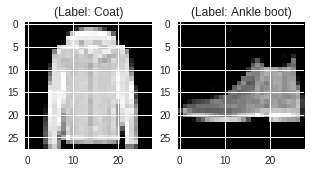

In [6]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(data.train.images[0], (28,28))
curr_lbl = np.argmax(data.train.labels[0,:])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(data.test.images[0], (28,28))
curr_lbl = np.argmax(data.test.labels[0,:])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

The output of above two plots are one of the sample images from both training and testing data, and these images are assigned a class label of 4 (Coat) and 9 (Ankle boot). Similarly, other fashion products will have different labels, but similar products will have same labels. This means that all the 6,500 ankle boot images will have a class label of 9.

In [7]:
# Data Preprocessing
print(np.max(data.train.images[0]))
print(np.min(data.train.images[0]))

# Reshape training and testing image (to 8 x 28 x 1, and feed this as an input to the network)
train_X = data.train.images.reshape(-1, 28, 28, 1)
test_X = data.test.images.reshape(-1,28,28,1)

1.0
0.0


In [8]:
print(train_X.shape)
print(test_X.shape)

(55000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
# Let's put the training and testing labels in separate variables
train_y = data.train.labels
test_y = data.test.labels

In [10]:
print(train_y.shape)
print(test_y.shape)

(55000, 10)
(10000, 10)


### The Deep Neural Network

We use three convolutional layers: the first layer will have 32-3 x 3 filters, the second layer will have 64-3 x 3 filters and the third layer will have 128-3 x 3 filters. In addition, there are three max-pooling layers each of size 2 x 2 between convolutional layers.



In [0]:
training_iters = 200 # number of times we train our network
learning_rate  = 0.001 # factor that is multiplied with the weights based on which the weights get updated 
batch_size     = 128 # training images will be divided in a fixed batch size to train on them

In [0]:
# MNIST data input (img shape: 28*28)
n_input = 28

# MNIST total classes (0-9 digits)
n_classes = 10

In [0]:
# Both placeholders are of type float
x = tf.placeholder("float", [None, 28,28,1])    # row dimension is None
y = tf.placeholder("float", [None, n_classes])  # row dimension is None

In [0]:
# Creating wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], 
                     padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [15]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Convolutional neural network architecture
def conv_net(x, weights, biases):  
    '''
    Function takes 3 arguments as an input: the input x and the weights and biases dictionaries
    '''

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [17]:
pred = conv_net(x, weights, biases)
print(pred)

Tensor("Add_1:0", shape=(?, 10), dtype=float32)


In [18]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
print(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Tensor("Mean:0", shape=(), dtype=float32)


In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
print(optimizer)

name: "Adam"
op: "NoOp"
input: "^Adam/update_W0/ApplyAdam"
input: "^Adam/update_W1/ApplyAdam"
input: "^Adam/update_W2/ApplyAdam"
input: "^Adam/update_W3/ApplyAdam"
input: "^Adam/update_W6/ApplyAdam"
input: "^Adam/update_B0/ApplyAdam"
input: "^Adam/update_B1/ApplyAdam"
input: "^Adam/update_B2/ApplyAdam"
input: "^Adam/update_B3/ApplyAdam"
input: "^Adam/update_B4/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"



### Evaluate Model Node


In [0]:
# Check whether the index of the maximum value of the predicted image is equal to the actual labelled image. 
# and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

In [0]:
# Calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
# Initializing the variables
init = tf.global_variables_initializer()

### Training and Testing the Model

In [23]:
with tf.Session() as sess:
  
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    
    for i in range(training_iters):
            
        for batch in range(len(train_X)//batch_size):
          
            batch_x = train_X[batch*batch_size: min((batch+1)*batch_size, len(train_X))]
            batch_y = train_y[batch*batch_size: min((batch+1)*batch_size, len(train_y))]  
            
            # Run optimization op (backprop).
            # And calculate batch loss and accuracy.
            opt = sess.run(optimizer, feed_dict={x: batch_x, 
                                                 y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
            
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 10000 mnist test images (test ==> validation set)
        valid_acc, valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(valid_acc)
        
        print("Testing Accuracy:","{:.5f}".format(valid_acc))
        
    summary_writer.close()

Iter 0, Loss= 0.366561, Training Accuracy= 0.86719
Optimization Finished!
Testing Accuracy: 0.84040
Iter 1, Loss= 0.230187, Training Accuracy= 0.91406
Optimization Finished!
Testing Accuracy: 0.87450
Iter 2, Loss= 0.184084, Training Accuracy= 0.92969
Optimization Finished!
Testing Accuracy: 0.88880
Iter 3, Loss= 0.151563, Training Accuracy= 0.93750
Optimization Finished!
Testing Accuracy: 0.89090
Iter 4, Loss= 0.136419, Training Accuracy= 0.95312
Optimization Finished!
Testing Accuracy: 0.88740
Iter 5, Loss= 0.119384, Training Accuracy= 0.96875
Optimization Finished!
Testing Accuracy: 0.88740
Iter 6, Loss= 0.123813, Training Accuracy= 0.94531
Optimization Finished!
Testing Accuracy: 0.88410
Iter 7, Loss= 0.094054, Training Accuracy= 0.96875
Optimization Finished!
Testing Accuracy: 0.89420
Iter 8, Loss= 0.088368, Training Accuracy= 0.96094
Optimization Finished!
Testing Accuracy: 0.90020
Iter 9, Loss= 0.092932, Training Accuracy= 0.95312
Optimization Finished!
Testing Accuracy: 0.90150


The test accuracy looks impressive, but is it?

Let's  plot the accuracy and loss plots between training and validation data to evaluate the model.

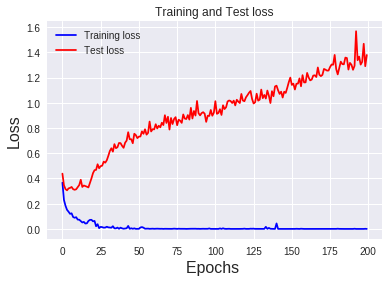

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

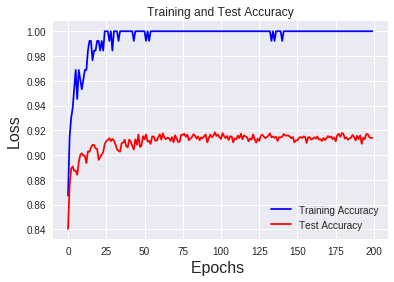

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

We see  that the model looks like it is overfitting since the training accuracy is more than the testing accuracy (showing the variational gap).

From the above two plots, you can see that the test accuracy almost became stagnant after 50-60 epochs and rarely increased at certain epochs. In the beginning, the validation accuracy was linearly increasing with loss, but then it did not increase much.

The validation loss shows that this is the sign of overfitting, similar to test accuracy it linearly decreased but after 25-30 epochs, it started to increase. This means that the model tried to memorize the data and succeeded.

One approach to improve and avoid against overfitting is to inject dropout layers in the neural network architecure to prevent the neurons, via the weights, from becomeing overly specialized in what they are learning. 